In [90]:
import re
import pandas as pd
import datetime as date
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import numpy as np

In [ ]:
# data read

In [41]:
data= pd.read_csv('C:/Users/86156/Desktop/clean_congress_bills_data.csv')
selected_columns = ['Sponsor','Committees','Vote Type', 'Vote Result','Status','Vote Result']
unique_counts_selected = data_clean[selected_columns].nunique()
print(unique_counts_selected)

Sponsor        411
Committees      75
Vote Type       79
Vote Result    691
Status          38
Vote Result    691
dtype: int64


In [ ]:
# data encode

In [42]:
#spilt bill number into 3 columns, major, sub and number
data['Bill Category'] = data['Bill Number'].apply(lambda x: re.match(r'^[A-Za-z\.]+', x).group() if re.match(r'^[A-Za-z\.]+', x) else 'Unknown')
data['Bill Order'] = data['Bill Number'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)
#define function
def categorize_bill(bill_category):
    if bill_category.startswith("H"):
        major_category = "House"
    elif bill_category.startswith("S"):
        major_category = "Senate"
    else:
        major_category = "Unknown"

    # Standardize common formats before classification
    standardized_category = bill_category.replace("HR", "H.R.").replace("S ", "S.")

    if standardized_category in ["H.R.", "S."]:
        sub_category = "Bill"
    elif standardized_category in ["H.J.Res.", "S.J.Res."]:
        sub_category = "Joint Resolution"
    elif standardized_category in ["H.Con.Res.", "S.Con.Res."]:
        sub_category = "Concurrent Resolution"
    elif standardized_category in ["H.Res.", "S.Res."]:
        sub_category = "Resolution"
    else:
        sub_category = "Unknown"

    return major_category, sub_category
data[['Major Category', 'Sub Category']] = data['Bill Number'].apply(lambda x: pd.Series(categorize_bill_fixed(x)))
#labelencode the bill number
major_category_encoder = LabelEncoder()
sub_category_encoder = LabelEncoder()

data['Major Category Encoded'] = major_category_encoder.fit_transform(data['Major Category'])
data['Sub Category Encoded'] = sub_category_encoder.fit_transform(data['Sub Category'])

# Generate final encoded bill number (combining major category, sub category, and order)
data['Bill Number Final Encoded'] = (data['Major Category Encoded'] * 1000000 + 
                                   data['Sub Category Encoded'] * 10000 + 
                                   data['Bill Order'])

In [43]:
#split result into 2 columns, one is [agreed,failed,no resulot],another is the difference of the vote
#define fuction
def extract_vote_details(vote_result):
    if isinstance(vote_result, str):
        # Determine if vote was "Agreed" or "Failed"
        outcome = "Agreed" if "Agreed" in vote_result else "Failed" if "Failed" in vote_result else "No Result"
        
        # Extract vote counts using regex
        match = re.search(r'(\d+)/(\d+)', vote_result)
        if match:
            votes_for = int(match.group(1))
            votes_against = int(match.group(2))
            vote_difference = votes_for - votes_against
        else:
            vote_difference = None
    else:
        outcome = "No Result"
        vote_difference = None
    
    return outcome, vote_difference
#adding new columns
data[['Vote Outcome', 'Vote Difference']] = data['Vote Result'].apply(lambda x: pd.Series(extract_vote_details(x)))

In [ ]:
# visulize whole correlation matrix

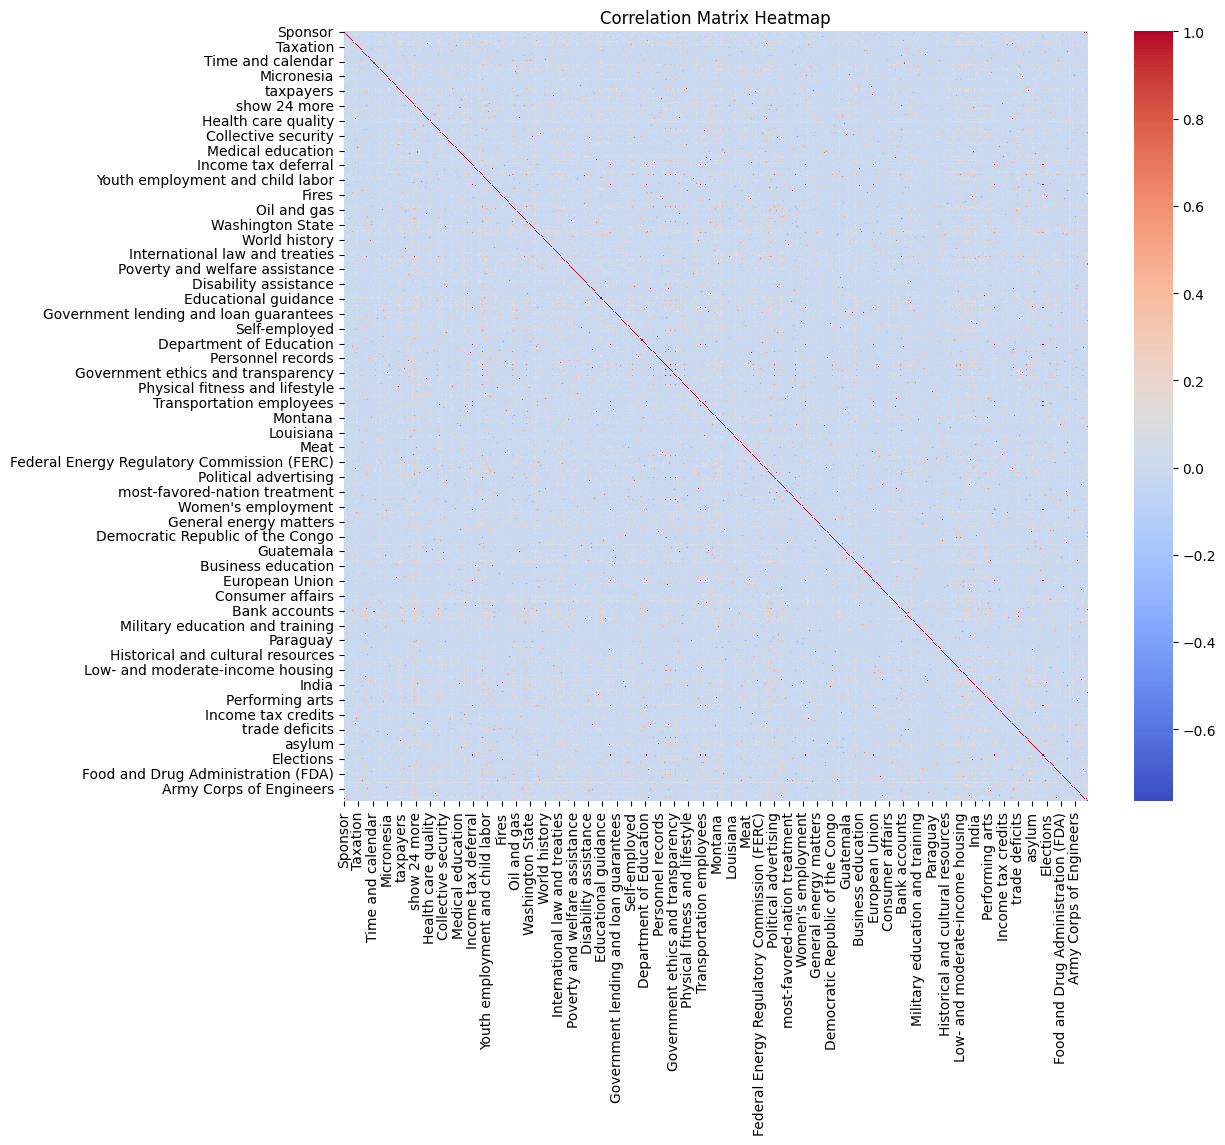

In [81]:
#encode object column as int
#using lable encoder cause too many unique value, by using one-hot encoding, too many columns will be generated
columns_to_encode = ['Sponsor', 'Committees', 'Vote Type', 'Vote Result', 'Status','Vote Outcome']
label_encoders = {}
for col in columns_to_encode:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col].fillna('Unknown'))
data_encoded = data.drop(columns=['Bill Number','Title'])
#drop all str or datetime column to generate corelation matrix
data_matrix = data_encoded.drop(columns=['Introduced','Vote Result','Related Bills','Status Date','Bill Order','Bill Category','Major Category','Sub Category','Vote Outcome'])
correlation_matrix_all = data_matrix.corr().fillna(0)
#show the whole feature matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [93]:
# top 5% correlation matrix

Loading Data:   0%|          | 0/100 [00:00<?, ?it/s]

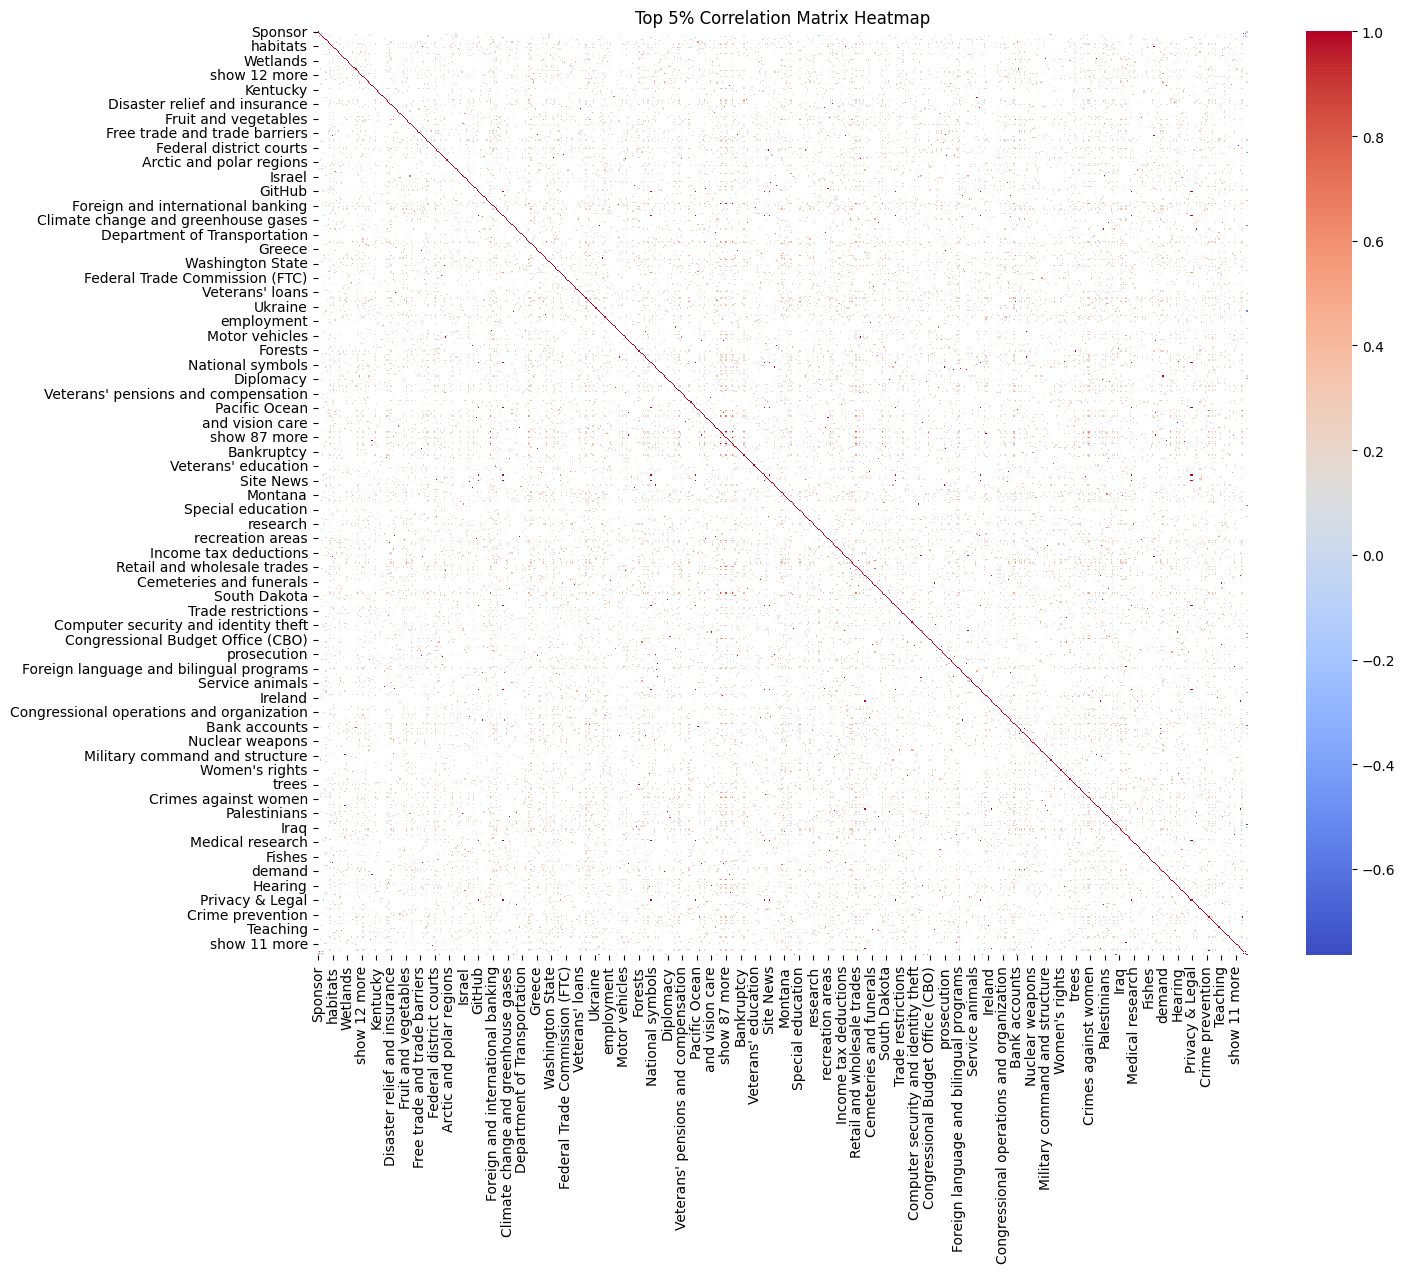

In [89]:
for i in tqdm(range(100), desc="Loading Data"):
    time.sleep(0.1)
#filter out low correlation, set 95% quantile as threshold
abs_corr_matrix = correlation_matrix_all.abs()
#set a mask to only show the bottom part of the plot cause they a symmetry
mask = np.triu(np.ones(abs_corr_matrix.shape, dtype=bool), k=1)
#sort the correlation
corr_values = abs_corr_matrix.where(mask).stack().sort_values(ascending=False)
#compute 95% quantile
top_10_percent_threshold = corr_values.quantile(0.95)
#save the top 5% value and set as nah to the rest
filtered_corr = correlation_matrix_all.where(abs(correlation_matrix_all) >= top_10_percent_threshold)
#plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(filtered_corr, cmap="coolwarm")
plt.title("Top 5% Correlation Matrix Heatmap")
plt.show()

In [91]:
# PCA

In [94]:
data_matrix

,Sponsor,Committees,Vote Type,Status,Cosponsor Count,Has Cosponsors,Chemistry,Terrorism,Customs enforcement,Income tax exclusion,...,Spacecraft and satellites,Joint Committee on Printing,Homeland security,support,Labor-management relations,cable,Major Category Encoded,Sub Category Encoded,Bill Number Final Encoded,Vote Difference
0,366,0,23,22,150,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,13.0
1,244,9,46,22,66,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2,-10.0
2,400,75,29,19,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,NaN
3,400,75,29,19,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,NaN
4,211,9,22,22,369,1,0,0,0,0,...,0,0,0,0,0,0,0,0,5,-20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,60,66,40,19,3,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1000118,NaN
1948,391,65,40,19,6,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1000119,NaN
1949,311,70,34,19,6,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1000120,NaN
1950,48,70,40,19,9,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1000121,NaN


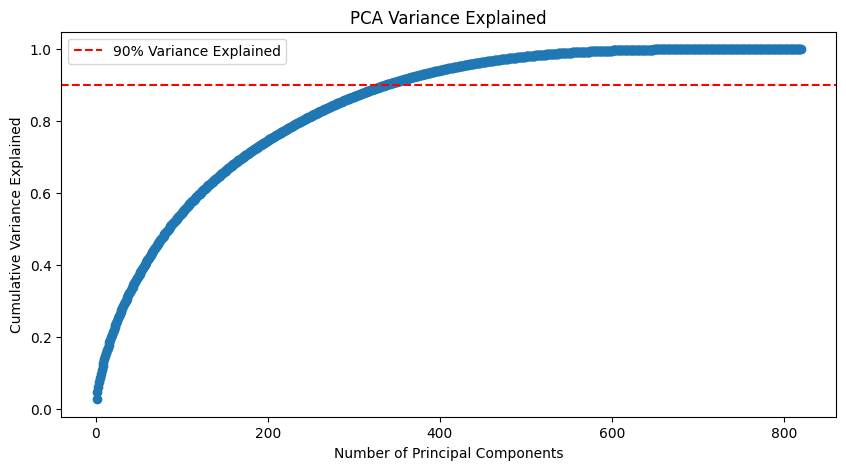

recommend 337 components


In [110]:
#as variables like sponsers, committees, etc. should be the depoendent variables, so we filter it out at first, then do the pca
data_pca=data_matrix.drop(columns=['Status','Sponsor','Committees','Vote Type','Cosponsor Count','Has Cosponsors','Major Category Encoded','Sub Category Encoded','Bill Number Final Encoded','Vote Difference'])
#standardized the data
scaler = StandardScaler()
data_pca_standard = scaler.fit_transform(data_pca)
#run pca and set minimal component as n
pca= PCA(n_components=min(data_pca_standard.shape))
principal_components = pca.fit_transform(data_pca_standard)
#calculate explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
#find varience>90%
num_components = np.argmax(explained_variance_ratio >= 0.90) + 1
#visulize variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Explained")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("PCA Variance Explained")
plt.legend()
plt.show()
print(f"recommend {num_components} components")
#run pca at recommended components
pca_adjusted = PCA(n_components=337)
principal_components_adjusted = pca_adjusted.fit_transform(data_pca_standard)
#generate new dataframe
data_after_pca = pd.DataFrame(principal_components_adjusted, columns=data_matrix.columns[:num_components])